In [ ]:
# ..... annotate cell clusters ..... #

In [45]:
library(Seurat)
library(SingleCellExperiment)
library(MetaNeighbor)

In [1]:
# get list of samples
stages = c(rep('stage23', 2), rep(c('stage28', 'stage32'), each = 3))
samples = c('sample3', 'sample10', 'sample5', 'sample10', 'sample11',
           'sample5', 'sample10', 'sample12')
days = c(rep('D4', 2), rep(c('D6', 'D8'), each = 3))

In [39]:
# load data
currstage = 'stage32'
sc1 = readRDS(paste0(currstage, '_integrated_cca.rds'))
dim(sc1@meta.data)

df1 = read.delim(paste0(currstage, '_metacell.csv'), sep = ',')
sc1$celltype = df1$metacell[match(rownames(sc1@meta.data), df1$barcode)]

df2 = read.delim(paste0(currstage, '_cluster_from_metacell_MN.csv'), sep = ',')
sc1$celltype2 = df2$cluster[match(sc1$celltype, df2$metacell)]
sc1$celltype3 = df2$cluster_mn[match(sc1$celltype, df2$metacell)]

sc1$stage <- sc1$orig.ident
sc1 <- sc1[,!is.na(sc1$celltype)]

# get metadata
cols = c('dataset', 'stage', 'celltype', 'celltype2', 'celltype3')
mtd1 = sc1@meta.data[,cols]
mtd1[1,]

[1] 21401    28

dataset stage   celltype celltype2 celltype3
stage32_sample5_AAACCCACATACTGTG-1 s5      stage32 1        cluster_1 cluster_1

In [40]:
# get cell anno from Mantri et al markers
mantridf = c()
ids = which(stages==currstage)
for(ii in ids){
    smp = samples[ii]
    temp = read.delim(paste0(currstage, '_', smp, '_mantri_celltypes.csv'), sep = ',')
    temp$sample = smp
    mantridf = rbind(mantridf, temp)
}
mantridf[1:3,]

group predicted                  score   
stage32_sample5_AAACCCACAAGGATGC-1 all   MT-enriched cardiomyocytes 3.229917
stage32_sample5_AAACCCACATACTGTG-1 all   Mural cells                2.217151
stage32_sample5_AAACCCACATCCTTGC-1 all   MT-enriched cardiomyocytes 3.374534
                                   enrichment sample 
stage32_sample5_AAACCCACAAGGATGC-1 1.980458   sample5
stage32_sample5_AAACCCACATACTGTG-1 1.784864   sample5
stage32_sample5_AAACCCACATCCTTGC-1 2.413584   sample5

In [41]:
mtd1$mantri_celltype <- mantridf$predicted[match(rownames(mtd1), rownames(mantridf))]
mtd1[1,]

dataset stage   celltype celltype2 celltype3
stage32_sample5_AAACCCACATACTGTG-1 s5      stage32 1        cluster_1 cluster_1
                                   mantri_celltype
stage32_sample5_AAACCCACATACTGTG-1 Mural cells

In [42]:
ctypes = unique(mtd1$celltype3)
cnames = unlist(lapply(1:length(ctypes), function(ii) (names(which.max(table(mtd1$mantri_celltype[mtd1$celltype3==ctypes[ii]]))))))
newdf = data.frame(cluster = ctypes, celltype = cnames)
newdf[1:3,]                       

cluster    celltype                  
1 cluster_1  Endocardial cells         
2 cluster_35 MT-enriched cardiomyocytes
3 cluster_46 Erythrocytes

In [43]:
# save list
write.table(newdf, file = 'list.csv', sep = ',', row.names = F, col.names = T, quote = F)

In [ ]:
# ................................................................................ #

In [77]:
# run MN on pairwise datasets #
anno = read.delim('stages3_cluster_annotation_Mantri.csv', sep = ',')
anno[1,]

stage   cluster    celltype          celltype_Mantri   label              
1 stage23 cluster_17 Endocardial cells Endocardial cells Endocardial cells_1

In [55]:
# get seurat integrated data
get_integrated_data <- function(currstage, anno_df){
    sc1 = readRDS(paste0(currstage, '_integrated_cca.rds'))
    DefaultAssay(sc1) <- 'RNA'
    
    df1 = read.delim(paste0(currstage, '_metacell.csv'), sep = ',')
    sc1$celltype = df1$metacell[match(rownames(sc1@meta.data), df1$barcode)]

    df2 = read.delim(paste0(currstage, '_cluster_from_metacell_MN.csv'), sep = ',')
    sc1$celltype2 = df2$cluster[match(sc1$celltype, df2$metacell)]
    sc1$celltype3 = df2$cluster_mn[match(sc1$celltype, df2$metacell)]
    
    sc1$cluster = anno_df$label[match(sc1$celltype3, anno_df$cluster)]
    sc1$annotation = anno_df$celltype[match(sc1$celltype3, anno_df$cluster)]
    
    sc1$stage <- sc1$orig.ident
    sc1 <- sc1[,!is.na(sc1$celltype)]
    return(sc1)
}

In [157]:
# load data
sc1 = get_integrated_data('stage28', anno)
sc2 = get_integrated_data('stage32', anno)

In [158]:
# get metadata
cols = c('dataset', 'stage', 'celltype', 'celltype2', 'celltype3',
         'cluster', 'annotation')

mtd1 = sc1@meta.data[,cols]
mtd2 = sc2@meta.data[,cols]
mtd0 = rbind(mtd1, mtd2)

In [159]:
# get commmon gene set
common_genes = intersect(rownames(sc1), rownames(sc2))
common_genes <- common_genes[!is.na(common_genes)]
length(common_genes)

[1] 17007

In [160]:
# make SCE object
sce = SingleCellExperiment(list(counts = cbind(sc1@assays$RNA@counts[common_genes,],
                                               sc2@assays$RNA@counts[common_genes,])),
                           colData = DataFrame(mtd0))
sce

class: SingleCellExperiment 
dim: 17007 48419 
metadata(0):
assays(1): counts
rownames(17007): SPRY2 PCDH20 ... ENSGALG00010000495 ENSGALG00010000377
rowData names(0):
colnames(48419): stage28_sample5_AAACCCAAGATTGGGC-1
  stage28_sample5_AAACCCAAGCGTATGG-1 ...
  stage32_sample12_TTTGTTGGTAGACGGT-1
  stage32_sample12_TTTGTTGGTGCTCGTG-1
colData names(7): dataset stage ... cluster annotation
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [161]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$stage)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

length(hvg)

if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

Time difference of 8.630063 secs

[1] 3764

In [162]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$stage, 
    cell_type = sce$cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$stage, 
    cell_type = sce$cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

In [163]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('\\_.*', '', sub('.*\\|', '', rownames(aurocsall)))

subs2 = c('Endocardial cells', 'Erythrocytes', 'Cardiomyocytes', 'Valve cells',  
          'Macrophages', 'Dendritic cells', 'Fibroblast cells',
          'Endothelial cells', 'Epithelial cells', 'Mural cells')
subcol2 = c('#574e3c', '#f87cc3', '#d43035', '#e78b00',  
            '#cd7883', '#651f7e', '#358957',
            '#4d9ec3', '#84b023', '#4900e6')
reg2 = c('stage28', 'stage32')
regcols2 = c('#bebebe', '#333333')

cols1 = subcol2[match(ctypes, subs2)]
cols2 = regcols2[match(exps, reg2)]

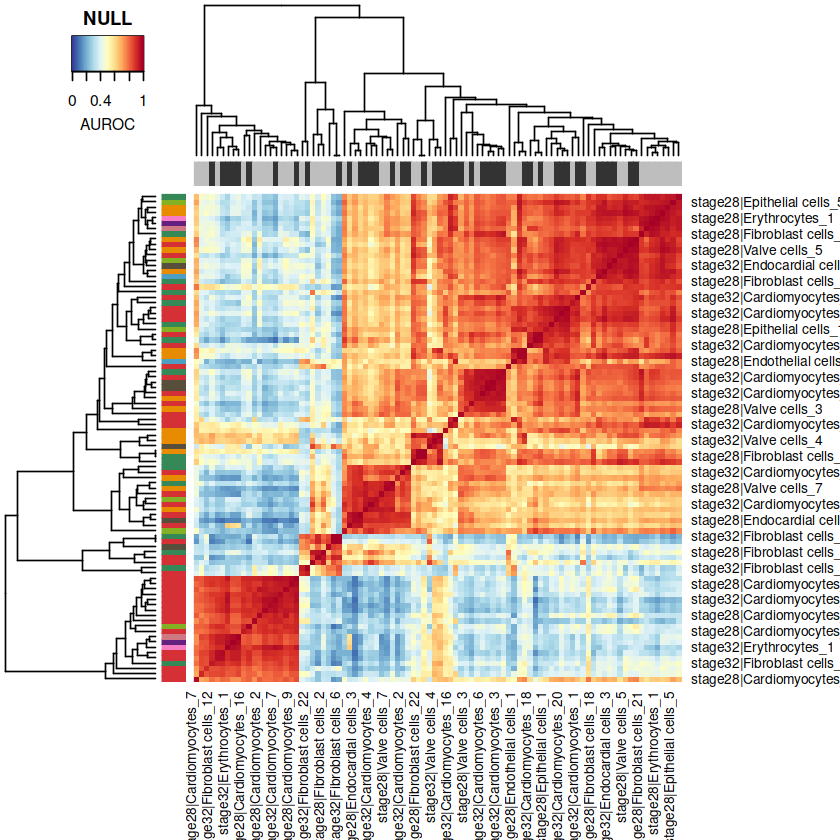

In [164]:
# png(paste0('aa-stage23_stage32_cluster_MN.png'), width = 15, height = 15, res = 300, units = 'in')
plotHeatmap(aurocsall, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [165]:
topdf = topHits(aurocsall, dat = sce, study_id = sce$stage, 
                cell_type = sce$cluster, threshold = 0.9)
dim(topdf)
tail(topdf)

[1] 61  4

Study_ID|Celltype_1        Study_ID|Celltype_2        Mean_AUROC
56 stage32|Cardiomyocytes_13  stage28|Cardiomyocytes_16  0.92      
57 stage28|Epithelial cells_2 stage32|Cardiomyocytes_4   0.92      
58 stage28|Cardiomyocytes_16  stage32|Epithelial cells_5 0.91      
59 stage28|Cardiomyocytes_11  stage32|Epithelial cells_1 0.91      
60 stage32|Cardiomyocytes_9   stage28|Valve cells_2      0.91      
61 stage28|Valve cells_1      stage32|Cardiomyocytes_17  0.90      
   Match_type        
56 Above_0.9         
57 Reciprocal_top_hit
58 Above_0.9         
59 Above_0.9         
60 Above_0.9         
61 Above_0.9

In [166]:
# save
write.table(topdf, file = 'stage28_stage32_links.csv', sep = ',', row.names = F,
           col.names = T, quote = F)

In [127]:
# get table of auroc > 0.9
diag(aurocsall) = 0
temp = aurocsall[grep('stage28', rownames(aurocsall)), grep('stage32', rownames(aurocsall))]
inds = which(temp>0.8, arr.ind = T)
rownames(inds) = NULL
head(inds)

row col
[1,] 1   2  
[2,] 2   3  
[3,] 5   3  
[4,] 6   3  
[5,] 7   3  
[6,] 8   3

In [128]:
linkdf = data.frame(cell1 = rownames(temp)[inds[,1]], cell2 = colnames(temp)[inds[,2]])
linkdf$auroc = unlist(lapply(1:dim(inds)[1], function(ii) (temp[inds[ii,1],inds[ii,2]])))
linkdf

cell1                     cell2                              auroc    
1  stage28|Cardiomyocytes    stage32|Dendritic cells            0.8029187
2  stage28|Dendritic cells   stage32|Endocardial cells          0.8696604
3  stage28|Erythrocytes      stage32|Endocardial cells          0.8718856
4  stage28|Fibroblast cells  stage32|Endocardial cells          0.8150494
5  stage28|Macrophages       stage32|Endocardial cells          0.8251236
6  stage28|Valve cells       stage32|Endocardial cells          0.9000849
7  stage28|Endocardial cells stage32|Epithelial cells           0.8137188
8  stage28|Cardiomyocytes    stage32|Erythrocytes               0.8246605
9  stage28|Cardiomyocytes    stage32|Macrophages                0.8046697
10 stage28|Dendritic cells   stage32|Valve cells                0.8060479
11 stage28|Erythrocytes      stage32|Valve cells                0.8295302
12 stage28|Dendritic cells   stage32|Vascular endothelial cells 0.9186208
13 stage28|Erythrocytes      stage32|Vascular endothelial cells 0.9335650
14 stage28|Macrophages       stage32|Vascular endothelial cells 0.8729868
15 stage28|Valve cells       stage32|Vascular endothelial cells 0.8274660

In [156]:
# save
# write.table(topdf, file = 'stage23_stage28_links.csv', sep = ',', row.names = F,
#            col.names = T, quote = F)